In [24]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os


loading the 6 datasets which includes the crisis and the corresponding total coverage received over the mentioned crisis days , the table also includes coverage quantitative;ly calculated per day,per required_funding,per people_effected

In [25]:
csv_dir = "../data/raw/"  

crisis_df = pd.read_csv(os.path.join(csv_dir, "chart1_overall_coverage_bar.csv"))
monthly_df = pd.read_csv(os.path.join(csv_dir, "chart3_monthly_coverage.csv"))
outlet_df = pd.read_csv(os.path.join(csv_dir, "chart4_crisis_coverage_per_outlet_chart.csv"))
framing_df = pd.read_csv(os.path.join(csv_dir, "framing_per_article.csv"))
sentiment_df = pd.read_csv(os.path.join(csv_dir, "sentiment_per_article.csv"))
victim_df = pd.read_csv(os.path.join(csv_dir, "victim_causor_per_article.csv"))

Assign crisis_id to the data frames

In [26]:
crisis_df = crisis_df.reset_index().rename(columns={"index":"crisis_id"})
crisis_df["crisis_id"] = crisis_df["crisis_id"] + 1  # Start IDs at 1

Create a mapping: crisis_name -> crisis_id

In [27]:

crisis_map = dict(zip(crisis_df["crisis_name"], crisis_df["crisis_id"]))

Adding crisis_id to child tables

In [28]:
monthly_df["crisis_id"] = monthly_df["crisis_name"].map(crisis_map)
outlet_df["crisis_id"] = outlet_df["crisis_name"].map(crisis_map)
framing_df["crisis_id"] = framing_df["crisis_name"].map(crisis_map)
sentiment_df["crisis_id"] = sentiment_df["crisis_name"].map(crisis_map)
victim_df["crisis_id"] = victim_df["crisis_name"].map(crisis_map)

try create SQLite DB

In [29]:
db_file = "humanitarian.db"
conn = sqlite3.connect(db_file)
cursor = conn.cursor()


To Run schema.sql

In [30]:
with open("../sql/schema.sql", "r") as f:
    cursor.executescript(f.read())

populating tables:

# Crises table

In [31]:
crisis_df[['crisis_id','crisis_name','start_date','fund_required','people_affected','crisis_days',
           'raw_coverage','coverage_per_day','coverage_per_funding','coverage_per_people']].to_sql(
    "crises", conn, if_exists="append", index=False)

10

In [32]:
crisis_df.head()

,crisis_id,crisis_name,raw_coverage,start_date,fund_required,people_affected,crisis_days,coverage_per_day,coverage_per_funding,coverage_per_people
0,1,Afghanistan,8302,8/1/2021,3.04,22.9,1287,6.450660,2730.921053,362.532751
1,2,Chad,349,7/1/2009,1.50,7.8,5701,0.061217,232.666667,44.743590
2,3,Democratic Republic of the Congo,1580,3/1/2022,3.23,21.2,1075,1.469767,489.164087,74.528302
3,4,Ethiopia,1511,11/1/2020,2.00,10.0,1560,0.968590,755.500000,151.100000
4,5,Gaza and the Occupied Palestinian Territories,29020,10/1/2023,4.00,3.3,496,58.508065,7255.000000,8793.939394


# Monthly coverage table

In [33]:
monthly_clean = monthly_df[['crisis_id', 'year_month', 'coverage_count']]

monthly_clean.to_sql(
    "monthly_coverage",
    conn,
    if_exists="append",
    index=False
)


734

In [34]:
monthly_clean.head()

,crisis_id,year_month,coverage_count
0,1,2021-08,3306
1,1,2021-09,981
2,1,2021-10,305
3,1,2021-11,212
4,1,2021-12,156


# Coverage by outlet table

In [35]:
outlet_clean = outlet_df[['crisis_id','matched_outlet',
                          'coverage_count','coverage_per_day',
                          'coverage_per_funding','coverage_per_people']]

outlet_clean = outlet_clean.rename(columns={'matched_outlet':'outlet_name'})

outlet_clean.to_sql("coverage_by_outlet", conn, if_exists="append", index=False)


403

In [36]:
outlet_clean.head()

,crisis_id,outlet_name,coverage_count,coverage_per_day,coverage_per_funding,coverage_per_people
0,1,ABC News,432,0.335664,142.105263,18.864629
1,1,AP News,291,0.226107,95.723684,12.707424
2,1,Al Jazeera,528,0.410256,173.684211,23.056769
3,1,BBC,562,0.436674,184.868421,24.541485
4,1,Birmigham Live,5,0.003885,1.644737,0.218341


# Framing type of article and respective counts 

In [37]:
framing_clean = framing_df[['crisis_id','outlet',
                            'framing','raw_count',
                            'article_count','mentions_per_article']]

framing_clean = framing_clean.rename(columns={
    'outlet':'outlet_name',
    'framing':'framing_type'
})

framing_clean.to_sql("framing", conn, if_exists="append", index=False)


471

In [38]:
framing_clean.head()

,crisis_id,outlet_name,framing_type,raw_count,article_count,mentions_per_article
0,5,USA Today,economic,4,408,0.009804
1,5,USA Today,geopolitical,109,408,0.267157
2,5,USA Today,humanitarian,151,408,0.370098
3,5,USA Today,legal,11,408,0.026961
4,5,USA Today,military,74,408,0.181373


# Sentiment abput how an related political entitiy/ famous personality is potryed in the artivle and respective count of mentions per article.

In [39]:
sentiment_clean = sentiment_df[['crisis_id','outlet',
                                'entity','sentiment',
                                'raw_count','mentions_per_article']]

sentiment_clean = sentiment_clean.rename(columns={'outlet':'outlet_name'})

sentiment_clean.to_sql("sentiment", conn, if_exists="append", index=False)


430

In [40]:
sentiment_clean.head()

,crisis_id,outlet_name,entity,sentiment,raw_count,mentions_per_article
0,9,USA Today,Putin,negative,106,0.410853
1,9,USA Today,Putin,neutral,13,0.050388
2,9,USA Today,Putin,positive,1,0.003876
3,9,USA Today,Zelensky,positive,55,0.213178
4,9,USA Today,Zelensky,neutral,20,0.077519


created a schema diagram using dbdiagram.io and is attached as .PNG in Docs/

## Visualization of data

which crises dominate media attention? we used bar graph to represent the values 

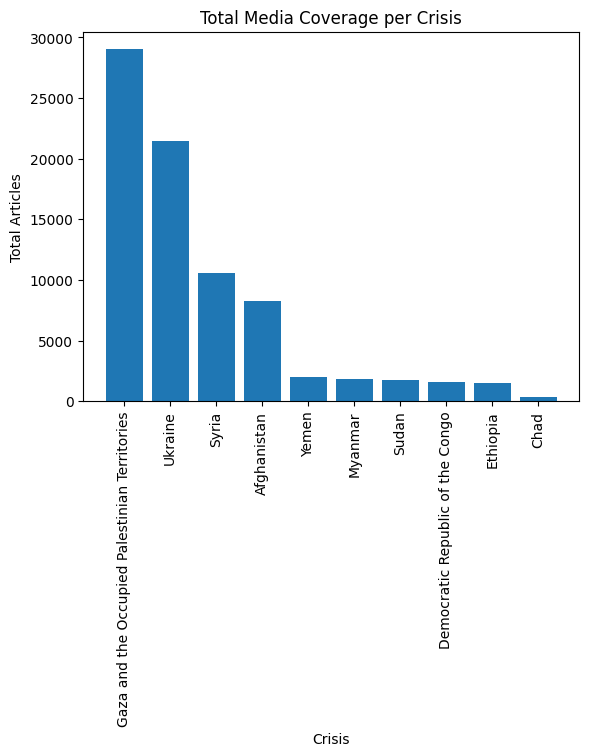

In [41]:
top_crisis = crisis_df.sort_values('raw_coverage', ascending=False)

plt.figure()
plt.bar(top_crisis['crisis_name'], top_crisis['raw_coverage'])
plt.xticks(rotation=90)
plt.title("Total Media Coverage per Crisis")
plt.xlabel("Crisis")
plt.ylabel("Total Articles")
plt.show()


Is coverage highly skewed? Monthly Coverage Trends : Line graph 

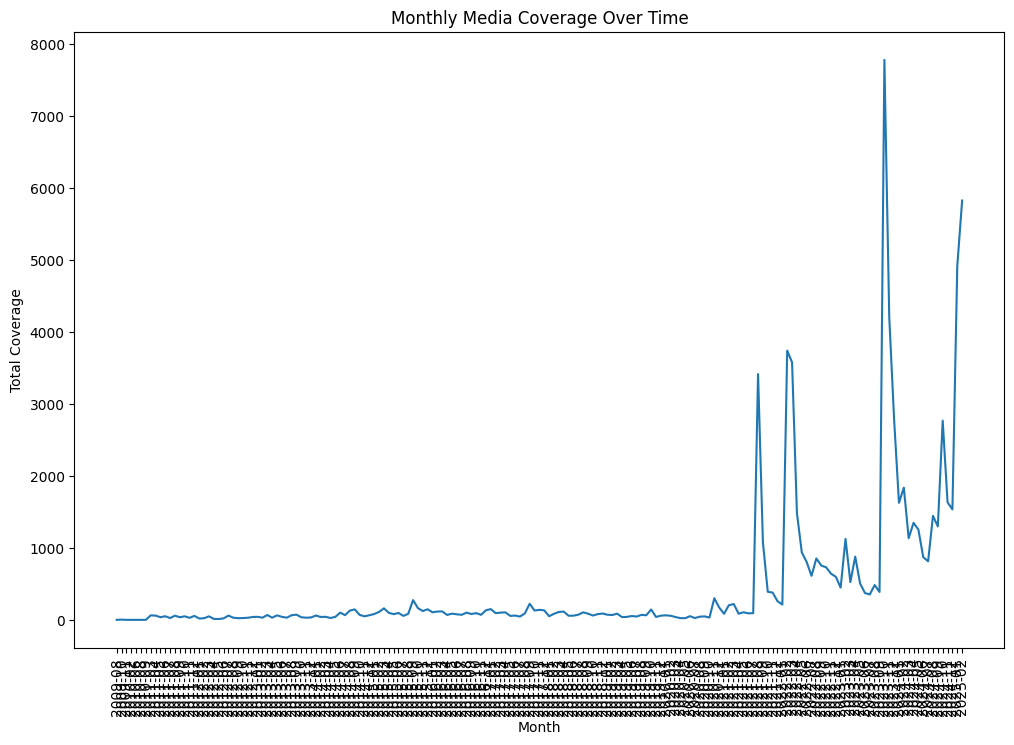

In [50]:
monthly_grouped = monthly_df.groupby('year_month')['coverage_count'].sum()

plt.figure(figsize=(12, 8))
plt.plot(monthly_grouped.index, monthly_grouped.values)
plt.xticks(rotation=90)
plt.title("Monthly Media Coverage Over Time")
plt.xlabel("Month")
plt.ylabel("Total Coverage")
plt.show()


Coverage by Outlet Bar chart rep 

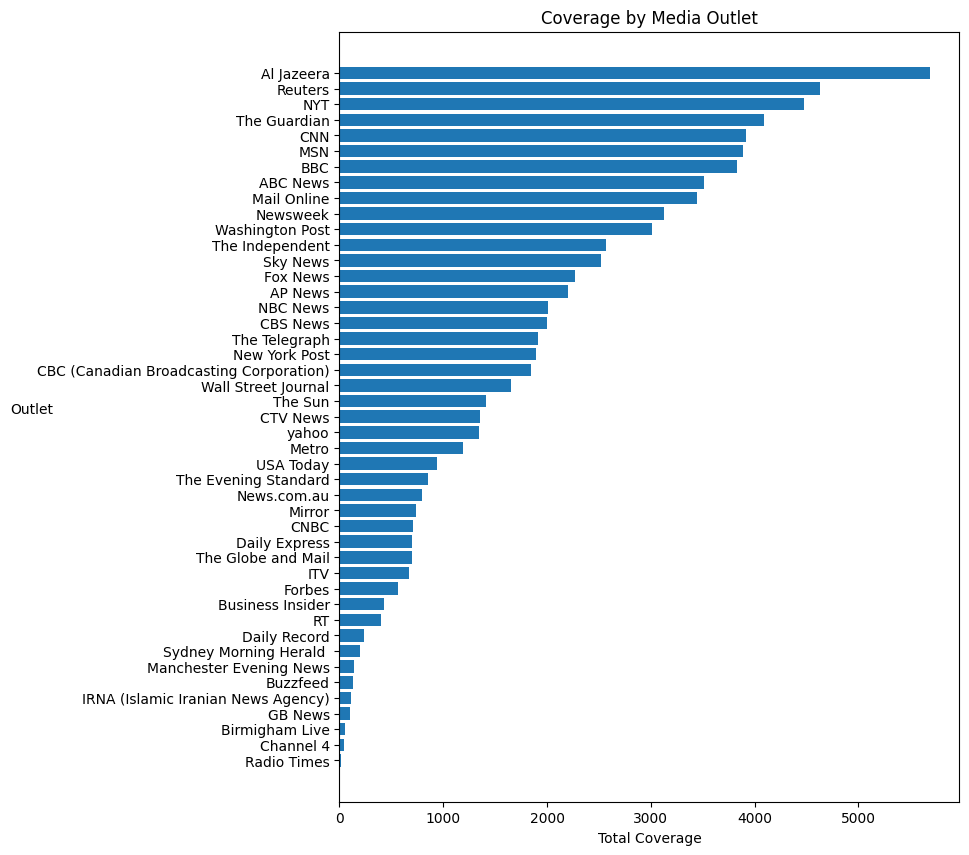

In [48]:
outlet_grouped = outlet_df.groupby('matched_outlet')['coverage_count'].sum().sort_values()

plt.figure(figsize=(8, 10))
plt.barh(outlet_grouped.index, outlet_grouped.values)
plt.title("Coverage by Media Outlet")
plt.xlabel("Total Coverage")
plt.ylabel("Outlet", rotation=0)
plt.show()
